In [1]:
!pip install -q pyomo

In [2]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pyomo.opt import SolverStatus, TerminationCondition
import time

## Subplots

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.cbook
import matplotlib.colors as mcolors

def subplot_drawing_n_3(revenue_list, total_surplus_list, surplus_list, price_list, access_list, d=None):
  d = {(i,j): 1 for i in [1,2,3] for j in [1,2,3]} if d == None else d
  fig, axs = plt.subplots(1, 4)
  fig.set_figheight(3.5)
  fig.set_figwidth(24)

  n_iter = len(revenue_list)
  iter_list = [i/(n_iter-1) for i in range(n_iter)] if n_iter != 1 else [0]
  axs[0].plot(iter_list, revenue_list, color='r', label = r'$\mathcal{R}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, total_surplus_list, color='g', label = r'$\mathcal{S}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', label = r'$\mathcal{W}(\alpha)$', linewidth=3.0)

  level = 0.8
  c = ['#069AF3', '#0343DF', '#FFA500', '#FF4500', '#15B01A', '#006400']
  index = [(1,2), (1,3), (2,1), (2,3), (3,1), (3,2)]
  for i in range(6):
    axs[1].plot(iter_list, [p[index[i]]/d[index[i]] for p in price_list], label=r'$p_{%s}$' %str(index[i])[1:-1], linewidth=3.0, color=c[i], alpha=level)

  for i in range(6):
    axs[2].plot(iter_list, [a[index[i]] for a in access_list], label=r'$A_{%s}$' %str(index[i])[1:-1], linewidth=3.0, color=c[i], alpha=level)

  for i in range(6):
    axs[3].plot(iter_list, [s[index[i]] for s in surplus_list], label=r'$\mathcal{S}_{%s}$' %str(index[i])[1:-1], linewidth=3.0, color=c[i], alpha=level)

  for j in range(4):
    axs[j].set_xlim([0, 1])
    axs[j].grid()

  for i in range(4):
      box = axs[i].get_position()
      axs[i].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
      axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), fancybox=True, shadow=True, ncol=3, prop={"size":10})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(18) #28

  plt.show()

In [5]:
def subplot_drawing_general(revenue_list, total_surplus_list, surplus_list, price_list, access_list):

  N = max(price_list[0].keys())[0]

  for i in range(1,N+1):
    fig, axs = plt.subplots(1, 3)
    fig.set_figheight(3.5)
    fig.set_figwidth(24)

    size = 20
    n_iter = len(total_surplus_list)
    iter_list = [i/(n_iter-1) for i in range(n_iter)] if n_iter != 1 else [0]

    level = 0.8

    line_colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'brown', 'pink']
    tableau_palette = mcolors.TABLEAU_COLORS
    line_colors = list(tableau_palette) + ['darkblue', 'rebeccapurple']
    for j in range(1,N+1):
      if i == j:
        continue
      line_color = line_colors[j-1]
      axs[0].plot(iter_list, [p[i,j] for p in price_list], label=r'$p_{%d,%d}$' %(i,j), linewidth=3.0, alpha=level, color=line_color)
      axs[1].plot(iter_list, [a[i,j] for a in access_list], label=r'$A_{%d,%d}$' %(i,j), linewidth=3.0, alpha=level, color=line_color)
      axs[2].plot(iter_list, [s[i,j] for s in surplus_list], label=r'$\mathcal{S}_{%d,%d}$' %(i,j), linewidth=3.0, alpha=level, color=line_color)

    for k in range(3):
      axs[k].set_xlim([0, 1])
      axs[k].grid()

    for k in range(3):
      box = axs[k].get_position()
      axs[k].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fancybox=True, shadow=True, ncol=4, prop={"size":10})

    for ax in axs.flat:
        ax.set(xlabel=r'$\alpha$')
        ax.xaxis.label.set_fontsize(18) #28

    plt.show()

In [6]:
def compare_n_3(opt, alg, fairness, criteria, d=None):
  d = {(i,j): 1 for i in [1,2,3] for j in [1,2,3]} if d == None else d
  revenue_list, total_surplus_list, surplus_list, price_list, access_list, weight_list = opt['rev'], opt['ts'], opt['s'], opt['p'], opt['a'], opt['w']
  rev_alg, ts_alg, sur_alg, p_alg, a_alg, w_alg = alg['rev'], alg['ts'], alg['s'], alg['p'], alg['a'], alg['w']

  if fairness == 'Price':
    rev_alg = rev_alg['lb']

  fig, axs = plt.subplots(1, 3)
  fig.set_figheight(3.5)
  fig.set_figwidth(18)

  line1 = (0, (3, 1, 1, 1))#(0, (1, 1))
  line2 = (0, (1, 1))

  n_iter = len(revenue_list)
  iter_list = [i/(n_iter-1) for i in range(n_iter)] if n_iter != 1 else [0]
  axs[0].plot(iter_list, revenue_list, color='r', label = r'$\mathcal{R}(\alpha)$', linewidth=3.0)
  if fairness == 'Price':
    axs[0].plot(iter_list, rev_alg, color='r', linewidth=3.0, label = r'$\hat{\mathcal{R}}(\alpha)$', linestyle = line1)
  else:
    axs[0].plot(iter_list, rev_alg['ub'], color='r', linewidth=3.0, label = r'$\hat{\mathcal{R}}_{ub}(\alpha)$', linestyle = line2)
    axs[0].plot(iter_list, rev_alg['lb'], color='r', linewidth=3.0, label = r'$\hat{\mathcal{R}}_{lb}(\alpha)$', linestyle = line1)
    rev_alg = rev_alg['lb']

  axs[0].plot(iter_list, total_surplus_list, color='g', label = r'$\mathcal{S}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, ts_alg, color='g', linewidth=3.0, label = r'$\hat{\mathcal{S}}(\alpha)$', linestyle = line1)

  axs[0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', label = r'$\mathcal{W}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, [rev_alg[i] + ts_alg[i] for i in range(n_iter)], color='b', label = r'$\hat{\mathcal{W}}(\alpha)$', linewidth=3.0, linestyle = line1)

  level = 0.8
  c = ['#069AF3', '#0343DF', '#FFA500', '#FF4500', '#15B01A', '#006400']
  index = [(1,2), (1,3), (2,1), (2,3), (3,1), (3,2)]
  for i in range(6):
    if fairness == 'Price' and criteria == 'trip':
      axs[1].plot(iter_list, [p[index[i]]/d[index[i]] for p in price_list], label=r'$p_{%s}$' %str(index[i])[1:-1], linewidth=3.0, color=c[i], alpha=level)
      axs[2].plot(iter_list, [p[index[i]]/d[index[i]] for p in p_alg], label=r'$\hat{p}_{%s}$' %str(index[i])[1:-1], linewidth=3.0, color=c[i], alpha=level, linestyle = line1)
    elif fairness == 'Access' and criteria == 'trip':
      axs[1].plot(iter_list, [a[index[i]] for a in access_list], label=r'$A_{%s}$' %str(index[i])[1:-1], linewidth=3.0, color=c[i], alpha=level)
      axs[2].plot(iter_list, [a[index[i]] for a in a_alg], label=r'$\hat{A}_{%s}$' %str(index[i])[1:-1], linewidth=3.0, color=c[i], alpha=level, linestyle = line1)

  c = [0, '#0343DF', '#FF4500', '#006400']
  for i in range(1,4):
    if fairness == 'Price' and criteria == 'origin':
      axs[1].plot(iter_list, [p[i] for p in weight_list['p_i']], label=r'$p_{%s}$' %str(i), linewidth=3.0, color=c[i], alpha=level)
      axs[2].plot(iter_list, [p[i] for p in w_alg['p_i']], label=r'$\hat{p}_{%s}$' %str(i), linewidth=3.0, color=c[i], alpha=level, linestyle = line1)
    elif fairness == 'Access' and criteria == 'origin':
      axs[1].plot(iter_list, [a[i] for a in weight_list['a_i']], label=r'$A_{%s}$' %str(i), linewidth=3.0, color=c[i], alpha=level)
      axs[2].plot(iter_list, [a[i] for a in w_alg['a_i']], label=r'$\hat{A}_{%s}$' %str(i), linewidth=3.0, color=c[i], alpha=level, linestyle = line1)


  for j in range(3):
    axs[j].set_xlim([0, 1])
    axs[j].grid()

  for i in range(3):
      box = axs[i].get_position()
      axs[i].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

  shadow = True
  if fairness == 'Price':
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), fancybox=True, shadow=shadow, ncol=3, prop={"size":14})
  else:
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.55), fancybox=True, shadow=shadow, ncol=3, prop={"size":14})

  if criteria == 'trip':
    if fairness == 'Price':
      axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.38), fancybox=True, shadow=shadow, ncol=3, prop={"size":14})
      axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.42), fancybox=True, shadow=shadow, ncol=3, prop={"size":14})
    else:
      axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.38), fancybox=True, shadow=shadow, ncol=3, prop={"size":14})
      axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.44), fancybox=True, shadow=shadow, ncol=3, prop={"size":14})
  else:
    if fairness == 'Price':
      axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, shadow=shadow, ncol=3, prop={"size":14})
      axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.27), fancybox=True, shadow=shadow, ncol=3, prop={"size":14})
    else:
      axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, shadow=shadow, ncol=3, prop={"size":14})
      axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.27), fancybox=True, shadow=shadow, ncol=3, prop={"size":14})

  for ax in axs.flat:
    ax.set(xlabel=r'$\alpha$')
    ax.xaxis.label.set_fontsize(18) #28

  plt.show()

## Price and Access Fair Model

In [7]:
def partition(m, n, depth=0):
    if n == depth:
        return [[]]
    return [
        item + [i]
        for i in range(m+1)
        for item in partition(m-i, n, depth=depth+1)
        ]

def combinations(m, n):
  return [[m-sum(p)] + p for p in partition(m, n-1)]

def z(m, n, r):
  z_m = 0
  for comb in combinations(m, n):
    z_m += prod([pow(r[i], comb[i]) for i in range(n)])
  return z_m

def availability(m, n, r):
  z_m = 0
  a = {i: 0 for i in range(1,n+1)}
  for comb in combinations(m, n):
    z_i = prod([pow(r[i], comb[i]) for i in range(n)])
    z_m += z_i
    for i in range(1,n+1):
      if comb[i-1] != 0:
        a[i] += z_i
  b = {i: a[i]/z_m for i in range(1,n+1)}
  return b

In [8]:
def optimization_problem(param, M_star = None, alpha = None, fairness = 'Price', criteria = 'group', solver='ipopt', init=None):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']

  model = ConcreteModel()
  L = [i for i in range(1,n+1)]

  model.pi = Var(L, domain = NonNegativeReals)
  model.r = Var(L, domain = NonNegativeReals)
  model.q = Var(L, L, domain = NonNegativeReals)

  model.revenue = Objective(expr = sum([log(k[i,j]*((1-model.q[i,j])/model.q[i,j]))/b[i,j]*market[i,j]*model.q[i,j]*model.pi[i] if i != j else 0 for i in L for j in L]), sense=maximize)

  # constraints
  model.c = ConstraintList()
  m_list = []
  for i in L:
    model.c.add(sum([market[i,j]*model.q[i,j]*model.r[i] if i != j else 0 for j in L]) == sum([market[k,i]*model.q[k,i]*model.r[k] if k!= i else 0 for k in L]))

    if fairness == 'Price' and criteria == 'origin':
      m_list.append(sum([market[i,j]*(log(k[i,j]*((1-model.q[i,j])/model.q[i,j]))/b[i,j])*1/d[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j]))
    elif fairness == 'Access' and criteria == 'origin':
      m_list.append(sum([market[i,j]*model.q[i,j]*model.pi[i] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]))

    for j in L:
      model.c.add(model.q[i,j] <= 1)
      if fairness == 'Price' and criteria == 'trip' and i != j:
        m_list.append((log(k[i,j]*((1-model.q[i,j])/model.q[i,j]))/b[i,j])*1/d[i,j])
      elif fairness == 'Access' and criteria == 'trip' and i != j:
        m_list.append(model.q[i,j]*model.pi[i])

  z_m = 0
  a = [0 for _ in L]
  for x in combinations(m, n):
    z = prod([pow(model.r[l], x[l-1]) for l in L])
    z_m += z
    for l in L:
      if x[l-1] > 0:
        a[l-1] += z
  model.c.add(z_m == 1)
  for l in L:
    model.c.add(model.pi[l] == a[l-1])

  # non-zero price
  for i in L:
    for j in L:
      model.c.add(model.q[i,j] <= k[i,j]/(1+k[i,j]))

  if alpha != None:
    eps = 1e-3 if alpha == 1 and criteria == 'Price' else 0
    for i in range(len(m_list)):
      for j in range(i+1, len(m_list)):
        model.c.add(m_list[i] - m_list[j] <= (1-alpha) * M_star + eps)
        model.c.add(m_list[j] - m_list[i] <= (1-alpha) * M_star + eps)

  if init == None:
    for i in L:
      model.pi[i].value = random.uniform(0, 1)  # Random value between 0 and 1
      model.r[i].value = random.uniform(0, 1)  # Random value between 0 and 1
      for j in L:
          model.q[i, j].value = random.uniform(0, 1)  # Random value between 0 and 1
  else:
    for i in L:
      model.pi[i].value = init['pi'][i]
      model.r[i].value = init['r'][i]
      for j in L:
          model.q[i, j].value = init['q'][i,j]
  _solver = SolverFactory(solver)

  if solver == 'couenne':
    _solver.options['tol'] = 1e-6
    _solver.options['max_iter'] = 10
  results = _solver.solve(model)
  return model

In [9]:
from functools import total_ordering
from re import sub
from pyomo.environ import *
import random

def fair_model(param, M_star=None, alpha=None, fairness = 'Price', criteria = 'trip', num_iter=10):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']

  L = [i for i in range(1,n+1)]

  solutions = []
  for iter in range(num_iter):
    try:
      model = optimization_problem(param, M_star = M_star,  alpha = alpha, fairness = fairness, criteria=criteria, solver='ipopt', init=None)
      solutions.append({'model': model,'revenue': model.revenue()})
    except:
      print("pass")
      pass

  best_solution = max(solutions, key=lambda sol: sol['revenue'])
  model = best_solution['model']
  p_ij, a_ij, org_q, sur = {}, {}, {}, {}
  total_surplus = 0

  price, sur, access, total_surplus = {}, {}, {}, 0
  for i in L:
    for j in range(1, n+1):
      org_q[i,j] = model.q[i,j]()
      if i != j:
        price[i,j] = np.log(k[i,j] * (1-model.q[i,j]())/model.q[i,j]())/b[i,j]
        access[i,j] = model.q[i,j]() * model.pi[i]()
        sur[i,j] = np.log(1+k[i,j]*np.exp(-b[i,j]*price[i,j])) * model.pi[i]() / b[i,j]
        total_surplus += market[i,j] * sur[i,j]

  if criteria == 'origin':
    weighted_p = []
    weighted_a = []
    for i in L:
      weighted_p.append(sum([market[i,j] * price[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j]))
      weighted_a.append(sum([market[i,j] * access[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j]))
    p_star = max(weighted_p) - min(weighted_p)
    a_star = max(weighted_a) - min(weighted_a)
  elif criteria == 'trip':
    p_star = max(price.values()) - min(price.values())
    a_star = max(access.values()) - min(access.values())
  star = {'p': p_star, 'a': a_star}

  return model, price, access, org_q, star, {'s': sur, 'ts': total_surplus}

In [10]:
def simulator(param, fairness = 'Price', criteria= 'trip', alpha_list = None, num_iter=10):
  n = param['n']
  L = [i for i in range(1,n+1)]

  revenue_list, surplus_list, total_surplus_list, p_list, a_list, q_list = [], [], [], [], [], []
  weighted_a, weighted_p = [], []

  market = param['market']
  fm, price, access, org_q, _star, sur_dict = fair_model(param, M_star=None, alpha=None, fairness=fairness, criteria=criteria, num_iter = num_iter)
  revenue_list.append(fm.revenue())
  surplus_list.append(sur_dict['s'])
  total_surplus_list.append(sur_dict['ts'])
  p_list.append(price)
  q_list.append(org_q)
  a_list.append(access)
  a_i = {k: sum([market[k,j] * access[k,j] for j in L if k != j])/sum([market[k,j] if k != j else 0 for j in L]) for k in L}
  weighted_a.append(a_i)
  p_i = {k: sum([market[k,j] * price[k,j] for j in L if k != j])/sum([market[k,j] for j in L if k != j]) for k in L}
  weighted_p.append(p_i)

  star = _star['p'] if fairness == 'Price' else _star['a']

  alpha_list = [a/10 for a in range(1, 11)] if alpha_list == None else alpha_list
  for a in alpha_list:
    print('alpha = %.1f' %a)
    fm, price, access, org_q, _star, sur_dict = fair_model(param, M_star = star, alpha=a, fairness=fairness, criteria=criteria, num_iter = num_iter)

    revenue_list.append(fm.revenue())
    surplus_list.append(sur_dict['s'])
    total_surplus_list.append(sur_dict['ts'])
    p_list.append(price)
    q_list.append(org_q)
    a_list.append(access)

    a_i = {k: sum([market[k,j] * access[k,j] for j in L if k != j])/sum([market[k,j] if k != j else 0 for j in L]) for k in L}
    weighted_a.append(a_i)
    p_i = {k: sum([market[k,j] * price[k,j] for j in L if k != j])/sum([market[k,j] for j in L if k != j]) for k in L}
    weighted_p.append(p_i)

  if n == 3:
    subplot_drawing_n_3(revenue_list, total_surplus_list, surplus_list, p_list, a_list)
  else:
    subplot_drawing_general(revenue_list, total_surplus_list, surplus_list, p_list, a_list)
  return revenue_list, total_surplus_list, surplus_list, p_list, q_list, a_list, {'a_i': weighted_a, 'p_i': weighted_p}

### Buzen's Algorithm

In [11]:
def buzens_algorithm(N, M, r):
  Tbl = {} # (0, 1, ..., M) x (1, 2, ...., N) matrix
  max_r = max(r)
  r = [ri/max_r for ri in r]
  r = [None] + r
  for n in range(1,N+1):
    Tbl[0,n] = 1
  for m in range(1,M+1):
    Tbl[m,1] = pow(r[1], m)

  for m in range(1, M+1):
    for n in range(2, N+1):
      Tbl[m,n] = Tbl[m,n-1] + r[n] * Tbl[m-1,n]
  return r[N]*Tbl[M-1,N]/Tbl[M,N]

def buzens_algorithm(N, M, r):
    max_r = max(r)
    r = [ri/max_r for ri in r]
    C = [1] + [0 for _ in range(M)]
    r = [None] + r
    C_num = 0
    for n in range(1, N+1):
      for m in range(1, M+1):
        C[m] = C[m] + r[n] * C[m-1]
    return r[N] * C[M-1]/C[M]

def get_pi(N, M, r):
  pi = {}
  for loc in range(len(r)):
    r_i = r[0:loc] + r[loc+1:] + [r[loc]]
    pi[loc+1] = buzens_algorithm(N, M, r_i)
  return pi

# print(pi(N,M,r))

In [12]:
import numpy as np
def get_r(Lambda, n):
  # convert dictionary to numpy array
  # inflow == outflow
  lambda_i_ = np.sum(Lambda, axis = 1) # sum_{j} lambda_ij
  A = Lambda.T - np.diag(lambda_i_)

  # Perform SVD on A
  U, s, Vt = np.linalg.svd(A)

  # Find the null space of A
  null_space = Vt.T[:, np.isclose(s, 0)]

  # Print a non-zero solution
  if null_space.size == 0:
      print("No non-zero solutions.")
  else:
      solution = null_space[:, 0]
      solution = np.abs(solution).tolist()
  pos = [element for element in solution if element > 0]
  return pos

## Example
Lambda = np.asarray([[0, 1/2,],[1/2, 0]])
r = get_r(Lambda, 2)
print(type(r))
print(r[0], r[1])

<class 'list'>
0.7071067811865475 0.7071067811865476


In [13]:
def true_value(param, q):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']

  Lambda = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      Lambda[i,j] = market[i+1,j+1] * q[i+1, j+1]
  r = get_r(Lambda, n)
  pi = get_pi(n, m, r)

  L = [i for i in range(1, n+1)]
  p = {}
  for i in L:
    for j in L:
      p[i,j] = np.log(k[i,j]*(1-q[i,j])/q[i,j])/b[i,j] if q[i,j] != 0 else np.inf

  revenue = sum([market[i,j]*p[i,j]*q[i,j]*pi[i] if i != j else 0 for i in L for j in L])

  sur, access, total_surplus = {}, {}, 0
  for i in L:
    for j in L:
      if i != j:
        sur[i,j] = np.log(1+k[i,j]*np.exp(-b[i,j]*p[i,j])) * pi[i] / b[i,j]
        access[i,j] = q[i,j] * pi[i]
        total_surplus += market[i,j] * sur[i,j]

  return revenue, {'s': sur, 'ts': total_surplus, 'r': pi}, access

## Approximated Problem (Access)

In [14]:
from functools import total_ordering
from re import sub
from pyomo.environ import *

def access_fair(param, M_star = None, alpha = 0, criteria = 'trip', solver = 'ipopt'):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']

  L = [i for i in range(1,n+1)]
  ### Step 1: Create an instance of the model
  model = ConcreteModel()

  ### Step 2: Define the decision
  model.q = Var(L, L, domain = NonNegativeReals)

  ### Step 3: Define Objective
  model.revenue = Objective(expr = sum([log(k[i,j]*((1-model.q[i,j])/model.q[i,j]))/b[i,j]*market[i,j]*model.q[i,j] if i != j else 0 for i in L for j in L]), sense=maximize)

  ### constraints
  model.c = ConstraintList()
  for i in L:
    for j in L:
      model.c.add(model.q[i,j] <= k[i,j]/(1+k[i,j])) # p >=0

  m_list = []
  for i in L:
    model.c.add(sum([market[i,j]*model.q[i,j] if i != j else 0 for j in L]) == sum([market[k,i]*model.q[k,i] if k!= i else 0 for k in L]))
    if criteria == 'origin':
      m_list.append(sum([market[i,j]*model.q[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]))
    for j in L:
      model.c.add(model.q[i,j] <= 1)
      if criteria == 'trip' and i != j:
        m_list.append(model.q[i,j])
  eps = 0
  if alpha != None:
    for i in range(len(m_list)):
      for j in range(i+1, len(m_list)):
        model.c.add(m_list[i] - m_list[j] <= (1-alpha) * M_star + eps)
        model.c.add(m_list[j] - m_list[i] <= (1-alpha) * M_star + eps)

  for i in L:
    for j in L:
        model.q[i, j].value = random.uniform(0, 1)  # Random value between 0 and 1

  _solver = SolverFactory(solver)
  results = _solver.solve(model)

  org_q = {(i,j): model.q[i,j]() for i in L for j in L}
  rev, sur, access = true_value(param, org_q)
  price = {(i,j):  np.log(k[i,j] * (1-org_q[i,j])/org_q[i,j])/b[i,j] for i in L for j in L}

  p_star, a_star = max(price.values())-min(price.values()), max(access.values())-min(access.values())
  star = {'p': p_star, 'a': a_star}

  return price, {'lb': rev, 'ub': model.revenue()}, sur, access

## Algorithm (Price) -- Heuristic

In [15]:
def trip_price_algorithm(param, price, alpha, num = 1000):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']
  L = [i for i in range(1,n+1)]
  for i in L:
    if (i,i) in price.keys():
      del price[i,i]

  p_dict = {(i,j): price[i,j]/d[i,j] for i in L for j in L if i != j}

  max_m = max(p_dict.values())
  min_m = min(p_dict.values())

  min_index = min(p_dict, key=p_dict.get)
  max_index = max(p_dict, key=p_dict.get)

  width_list = [(1-alpha) * (max_m - min_m), (1-alpha-0.05) * (max_m - min_m)] if alpha != 1 else [0]

  opt_obj = 0
  opt_sur = {'ts': 0, 's': {(i,j):0 for i in L for j in L}}
  opt_access = {(i,j):0 for i in L for j in L}
  opt_p = {(i,j):0 for i in L for j in L}

  for width in width_list:
    center = min_m - width/2
    step = (max_m - min_m + width) / num
    cnt = 0

    while cnt <= num:
      p_dict_feasible = {}
      bottom, top = max(center - width/2, 0), center + width/2

      bottom_hit, top_hit = False, False
      for i in L:
        for j in L:
          if i == j:
            continue
          if p_dict[i,j] < bottom:
            p_dict_feasible[i,j] = bottom
            bottom_hit = True
          if p_dict[i,j] > top:
            p_dict_feasible[i,j] = top
            top_hit = True
          if p_dict[i,j] >= bottom and p_dict[i,j] <= top:
            p_dict_feasible[i,j] = p_dict[i,j]

      p_dict_feasible_alt = p_dict_feasible.copy()
      if bottom_hit and top_hit:
        pass
      elif bottom_hit:
        p_dict_feasible_alt[max_index] = top
      elif top_hit:
        p_dict_feasible_alt[min_index] = bottom

      # price/dist (or price/time) -> price
      p1 = {(i,j): p_dict_feasible[i,j]*d[i,j] for i in L for j in L if i != j}
      p2 = {(i,j): p_dict_feasible_alt[i,j]*d[i,j] for i in L for j in L if i != j}

      eps = 0
      q1 = {(i,j): k[i,j] * np.exp(-b[i,j] * p1[i,j])/(1+k[i,j] * np.exp(-b[i,j] * p1[i,j])) for i in L for j in L if i != j}
      q2 = {(i,j): k[i,j] * np.exp(-b[i,j] * p2[i,j])/(1+k[i,j] * np.exp(-b[i,j] * p2[i,j])) for i in L for j in L if i != j}

      q1.update({(i,i): 0 for i in L})
      q2.update({(i,i): 0 for i in L})

      obj_alg_1, sur_1, access_1 = true_value(param, q1)
      obj_alg_2, sur_2, access_2 = true_value(param, q2)

      if obj_alg_1 > opt_obj:
        opt_obj = obj_alg_1
        opt_p = p1
        opt_sur = sur_1
        opt_access = access_1

      if obj_alg_2 > opt_obj:
        opt_obj = obj_alg_2
        opt_p = p2
        opt_sur = sur_2
        opt_access = access_2

      center += step
      cnt += 1

  return opt_p, opt_obj, opt_sur, opt_access

In [16]:
def origin_price_algorithm(param, price, alpha, num = 1000):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']
  L = [i for i in range(1,n+1)]
  p_i = {k: sum([market[k,j] * price[k,j]/d[k,j] if k != j else 0 for j in L])/sum([market[k,j] if k != j else 0 for j in L]) for k in L}
  C_star = max(p_i.values()) - min(p_i.values())
  for i in L:
    if (i,i) in price.keys():
      del price[i,i]

  p_dict = {(i,j): price[i,j]/d[i,j] for i in L for j in L if i != j}

  max_m = max(p_dict.values())
  min_m = min(p_dict.values())

  min_index = min(p_dict, key=p_dict.get)
  max_index = max(p_dict, key=p_dict.get)

  grid = [i/100 for i in range(10)]
  width_list = [(1-alpha-k) * (max_m - min_m) for k in grid] if alpha != 1 else [0]

  opt_obj = 0
  opt_sur = {'ts': 0, 's': {(i,j):0 for i in L for j in L}}
  opt_access = {(i,j):0 for i in L for j in L}
  opt_p = {(i,j):0 for i in L for j in L}

  for width in width_list:
    center = min_m - width/2
    step = (max_m - min_m + width) / num
    cnt = 0

    while cnt <= num:
      p_dict_feasible = {}
      bottom, top = max(center - width/2, 0), center + width/2
      # print(bottom, top)
      bottom_hit, top_hit = False, False
      for i in L:
        for j in L:
          if i == j:
            continue
          if p_dict[i,j] < bottom:
            p_dict_feasible[i,j] = bottom
            bottom_hit = True
          if p_dict[i,j] > top:
            p_dict_feasible[i,j] = top
            top_hit = True
          if p_dict[i,j] >= bottom and p_dict[i,j] <= top:
            p_dict_feasible[i,j] = p_dict[i,j]

      p_dict_feasible_alt = p_dict_feasible.copy()
      if bottom_hit and top_hit:
        pass
      elif bottom_hit:
        p_dict_feasible_alt[max_index] = top
      elif top_hit:
        p_dict_feasible_alt[min_index] = bottom

      p_i1 = {k: sum([market[k,j] * p_dict_feasible[k,j] for j in L if k != j])/sum([market[k,j] for j in L if k != j]) for k in L}
      if max(p_i1.values()) - min(p_i1.values()) <= (1-alpha) * C_star:
        p1 = {(i,j): p_dict_feasible[i,j]*d[i,j] for i in L for j in L if i != j}
        q1 = {(i,j): 1/(1+np.exp(b[i,j] * p1[i,j])/k[i,j]) for i in L for j in L if i != j}
        q1.update({(i,i): 0 for i in L})
        obj_alg_1, sur_1, access_1 = true_value(param, q1)

        if obj_alg_1 > opt_obj:
          opt_obj = obj_alg_1
          opt_p = p1
          opt_sur = sur_1
          opt_access = access_1

      p_i2 = {k: sum([market[k,j] * p_dict_feasible_alt[k,j] for j in L if k != j])/sum([market[k,j] for j in L if k != j]) for k in L}
      if max(p_i2.values()) - min(p_i2.values()) <= (1-alpha) * C_star:
        p2 = {(i,j): p_dict_feasible_alt[i,j]*d[i,j] for i in L for j in L if i != j}
        q2 = {(i,j): 1/(1+np.exp(b[i,j] * p2[i,j])/k[i,j]) for i in L for j in L if i != j}
        q2.update({(i,i): 0 for i in L})
        obj_alg_2, sur_2, access_2 = true_value(param, q2)

        if obj_alg_2 > opt_obj:
          opt_obj = obj_alg_2
          opt_p = p2
          opt_sur = sur_2
          opt_access = access_2

      center += step
      cnt += 1

  return opt_p, opt_obj, opt_sur, opt_access

In [17]:
def algorithm_simulator(param, fairness = 'Access', criteria = 'trip', num = 1000, step = 0.1, Delta_W=0.1):
  n = param['n']
  start_time = time.time()
  fm, price, access, org_q, _star, sur = fair_model(param, M_star=None, alpha=None, criteria=criteria)
  print('algorithm start')
  p_star, a_star = _star['p'], _star['a']
  print('price gap', p_star)
  print('access gap', a_star)

  revenue_list, total_surplus_list, surplus_list, p_list, a_list = [], [], [], [], []
  revenue_ub = []
  weighted_a, weighted_p = [], []
  L = [i for i in range(1, param['n']+1)]

  alpha_list = [1e-4] + [i/10 for i in range(1, 11)]
  alpha_list = reversed(alpha_list)
  prev_opt_obj = 0
  for alpha in alpha_list:
    if fairness == 'Price':
      if alpha == 0:
        opt_price, opt_obj, opt_sur, opt_access = price, fm.revenue(), sur, access
      else:
        if criteria == 'origin':
          opt_price, opt_obj, opt_sur, opt_access = origin_price_algorithm(param, price, alpha, num=num)
        if criteria == 'trip':
          opt_price, opt_obj, opt_sur, opt_access = trip_price_algorithm(param, price, alpha, num=num)
    elif fairness == 'Access':
      solutions = []
      for iter in range(10):
        try:
          opt_price, rev, opt_sur, opt_access = access_fair(param, M_star = a_star, alpha = alpha, criteria = criteria, solver = 'ipopt')
          solutions.append({'rev': rev, 'opt_price': opt_price, 'opt_sur': opt_sur, 'opt_access': opt_access})
        except:
          print(f"fail at {iter}")
          pass

      best_solution = max(solutions, key=lambda sol: sol['rev']['lb'])

      opt_obj = best_solution['rev']['lb']
      revenue_ub = [best_solution['rev']['ub']] + revenue_ub
      opt_sur = best_solution['opt_sur']
      opt_price = best_solution['opt_price']
      opt_access = best_solution['opt_access']

    if opt_obj > prev_opt_obj:
      revenue_list = [opt_obj] + revenue_list
      total_surplus_list = [opt_sur['ts']] + total_surplus_list
      surplus_list = [opt_sur['s']] + surplus_list
      p_list = [opt_price] + p_list
      a_list = [opt_access] + a_list

      market = param['market']
      a_i = {k: sum([market[k,j] * opt_access[k,j] if k != j else 0 for j in L])/sum([market[k,j] if k != j else 0 for j in L]) for k in L}
      weighted_a= [a_i] + weighted_a
      p_i = {k: sum([market[k,j] * opt_price[k,j] if k != j else 0 for j in L])/sum([market[k,j] if k != j else 0 for j in L]) for k in L}
      weighted_p = [p_i] + weighted_p
    else:
      revenue_list = [revenue_list[0]] + revenue_list
      total_surplus_list = [total_surplus_list[0]] + total_surplus_list
      surplus_list = [surplus_list[0]] + surplus_list
      p_list = [p_list[0]] + p_list
      a_list = [a_list[0]] + a_list

      weighted_a = [weighted_a[0]] + weighted_a
      weighted_p = [weighted_p[0]] + weighted_p

    prev_opt_obj = opt_obj

  subplot_drawing_n_3(revenue_list, total_surplus_list, surplus_list, p_list, a_list)

  print('time elapsed %.2f min' %((time.time()-start_time)/60))

  return {'lb': revenue_list, 'ub': revenue_ub}, total_surplus_list, surplus_list, p_list, a_list, {'a_i': weighted_a, 'p_i': weighted_p}

## Experiments

In [18]:
n = 3
m = 10

param = {'market': {(1, 2): 10, (1, 3): 4, (2, 1): 3, (2, 3): 5, (3, 1): 2, (3, 2): 9, (1, 1): 0, (2, 2): 0, (3, 3): 0}, 'b': {(1, 1): 0.125, (1, 2): 0.2, (1, 3): 0.16666666666666666, (2, 1): 0.125, (2, 2): 0.2, (2, 3): 0.1, (3, 1): 0.3333333333333333, (3, 2): 0.3333333333333333, (3, 3): 1.0}, 'k': {(1, 1): 1, (1, 2): 1, (1, 3): 1, (2, 1): 1, (2, 2): 1, (2, 3): 1, (3, 1): 1, (3, 2): 1, (3, 3): 1}, 'n': 3, 'm': 10, 'd': {(1, 1): 1, (1, 2): 1, (1, 3): 1, (2, 1): 1, (2, 2): 1, (2, 3): 1, (3, 1): 1, (3, 2): 1, (3, 3): 1}}
print(param)

{'market': {(1, 2): 10, (1, 3): 4, (2, 1): 3, (2, 3): 5, (3, 1): 2, (3, 2): 9, (1, 1): 0, (2, 2): 0, (3, 3): 0}, 'b': {(1, 1): 0.125, (1, 2): 0.2, (1, 3): 0.16666666666666666, (2, 1): 0.125, (2, 2): 0.2, (2, 3): 0.1, (3, 1): 0.3333333333333333, (3, 2): 0.3333333333333333, (3, 3): 1.0}, 'k': {(1, 1): 1, (1, 2): 1, (1, 3): 1, (2, 1): 1, (2, 2): 1, (2, 3): 1, (3, 1): 1, (3, 2): 1, (3, 3): 1}, 'n': 3, 'm': 10, 'd': {(1, 1): 1, (1, 2): 1, (1, 3): 1, (2, 1): 1, (2, 2): 1, (2, 3): 1, (3, 1): 1, (3, 2): 1, (3, 3): 1}}


### Price Fairness

alpha = 0.1


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.2
alpha = 0.3
alpha = 0.4
alpha = 0.5
alpha = 0.6
alpha = 0.7
alpha = 0.8
alpha = 0.9
alpha = 1.0


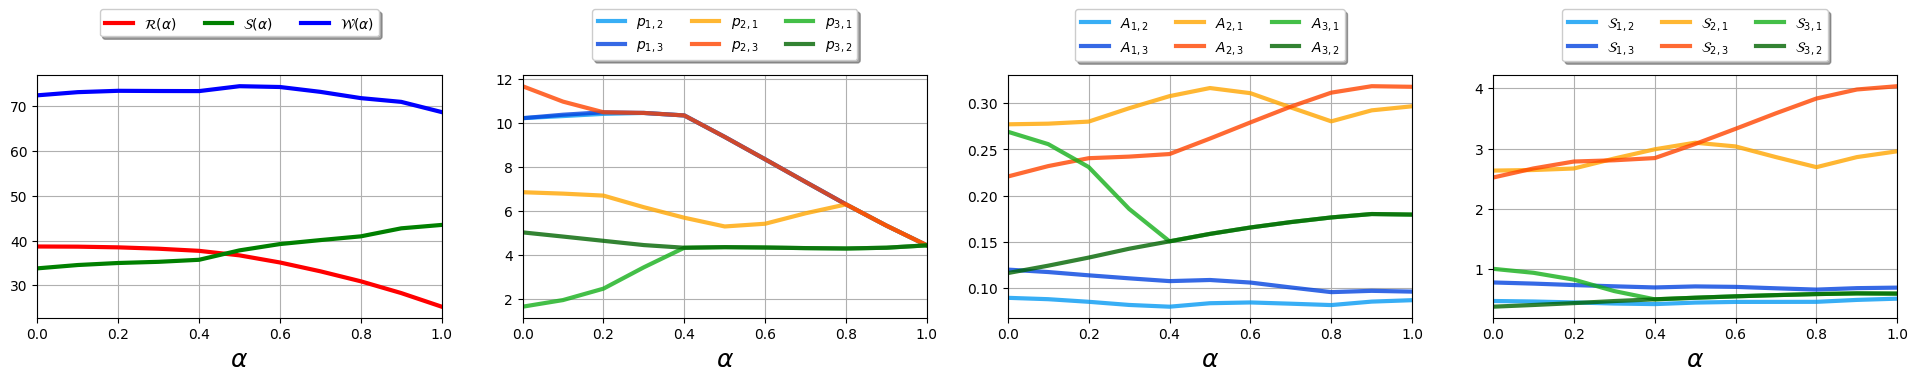

In [19]:
rev_opt, total_sur_opt, sur_opt, p_opt, q_opt, a_opt, weighted_opt = simulator(param, fairness='Price', criteria='trip')
opt = {'rev': rev_opt, 'ts': total_sur_opt, 's': sur_opt, 'p': p_opt, 'q': q_opt, 'a': a_opt, 'w': weighted_opt}

algorithm start
price gap 10.037871468930383
access gap 0.18814228830830726


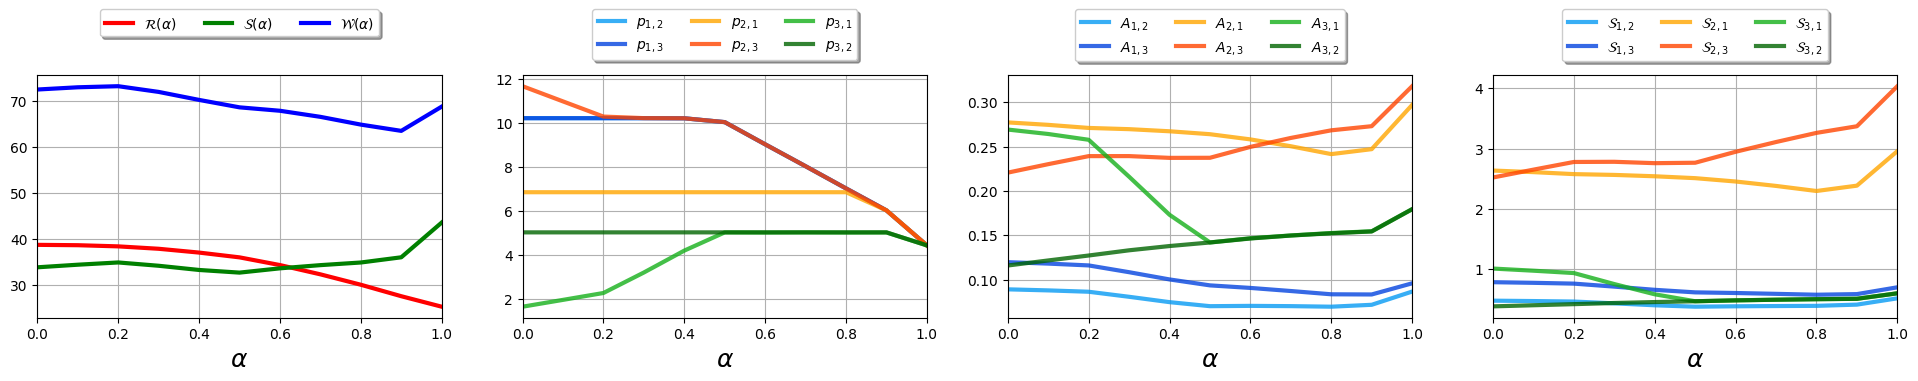

time elapsed 0.23 min


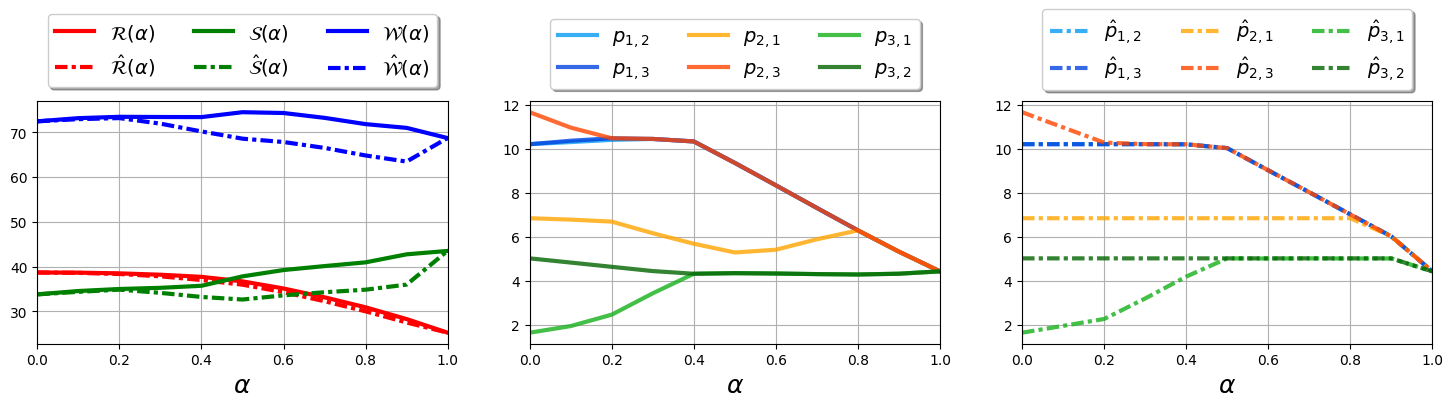

In [20]:
rev_alg, total_sur_alg, sur_alg, p_alg, a_alg, weighted_alg = algorithm_simulator(param, fairness = 'Price', criteria='trip', step=0.1, Delta_W=0.1)
alg = {'rev': rev_alg, 'ts': total_sur_alg, 's': sur_alg, 'p': p_alg, 'a': a_alg, 'w': weighted_alg}
compare_n_3(opt, alg, fairness='Price', criteria='trip')

In [21]:
# import pickle
# save_path = '/path/for/pkl/file'
# file_name = f'Price_trip.pkl'
# with open(os.path.join(save_path, file_name), 'wb') as f:
#   pickle.dump({'opt': opt, 'alg': alg}, f)

alpha = 0.1
alpha = 0.2


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.3
alpha = 0.4
pass
alpha = 0.5
alpha = 0.6
alpha = 0.7
alpha = 0.8


  - termination condition: infeasible
  - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible point. Problem may be infeasible.


alpha = 0.9
alpha = 1.0


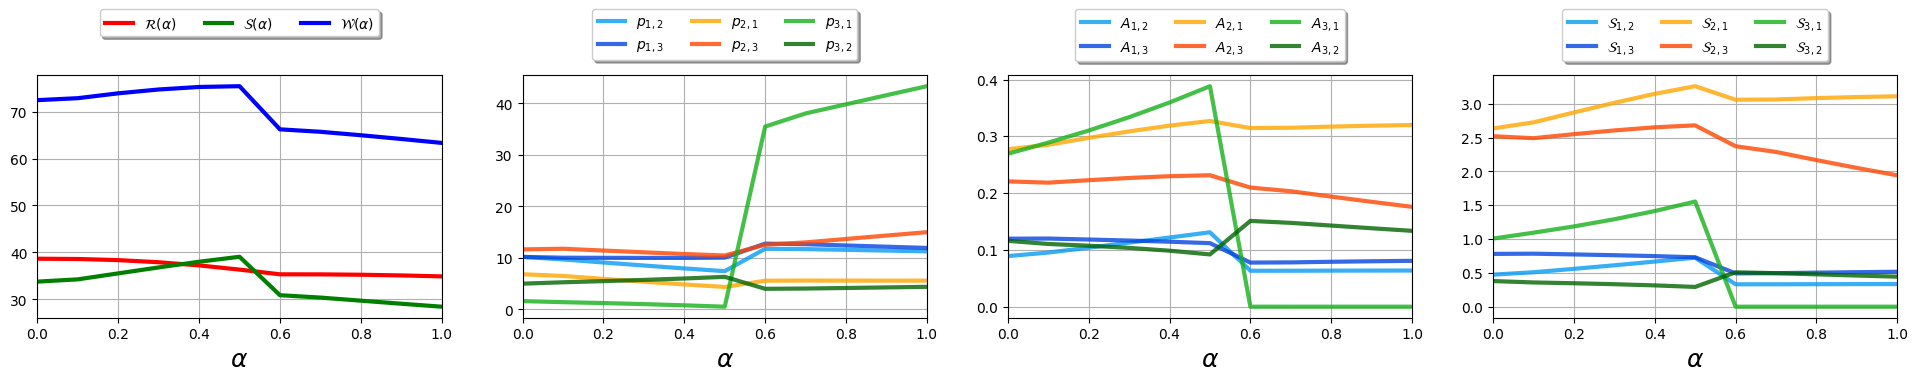

In [22]:
rev_opt, total_sur_opt, sur_opt, p_opt, q_opt, a_opt, weighted_opt = simulator(param, fairness='Price', criteria='origin')
opt = {'rev': rev_opt, 'ts': total_sur_opt, 's': sur_opt, 'p': p_opt, 'q': q_opt, 'a': a_opt, 'w': weighted_opt}

algorithm start
price gap 5.813867115200354
access gap 0.14401274460630153


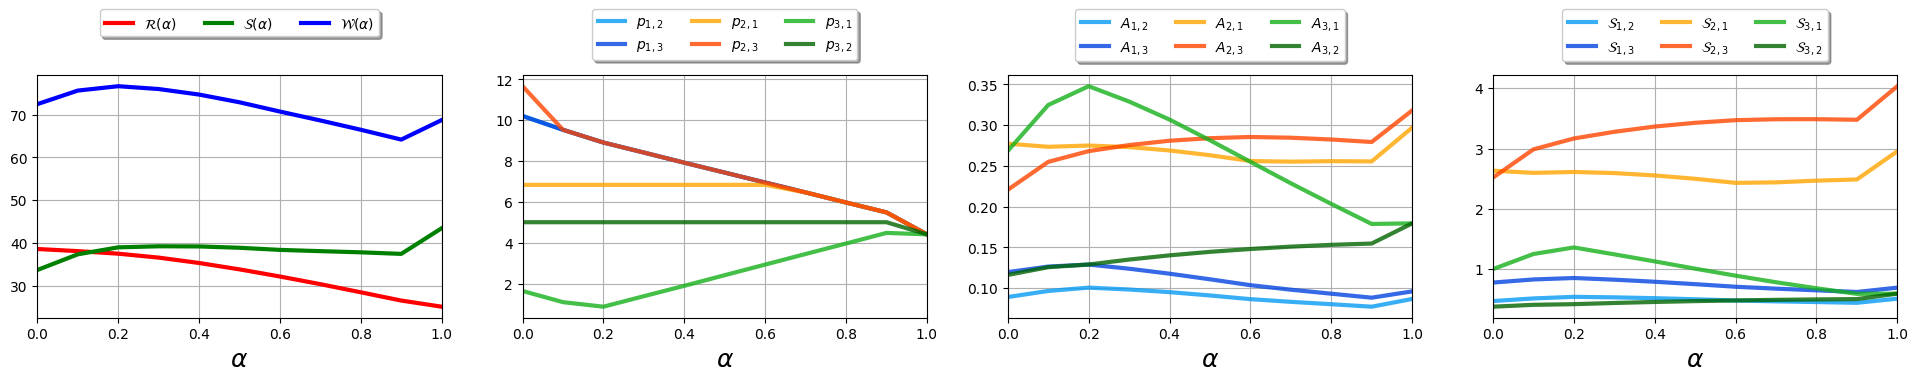

time elapsed 0.71 min


In [23]:
rev_alg, total_sur_alg, sur_alg, p_alg, a_alg, weighted_alg = algorithm_simulator(param, fairness = 'Price', criteria='origin', step=0.1, Delta_W=0.1)
alg = {'rev': rev_alg, 'ts': total_sur_alg, 's': sur_alg, 'p': p_alg, 'a': a_alg, 'w': weighted_alg}

In [24]:
# save_path = '/path/for/pkl/file'
# file_name = f'Price_origin.pkl'
# with open(os.path.join(save_path, file_name), 'wb') as f:
#   pickle.dump({'opt': opt, 'alg': alg}, f)

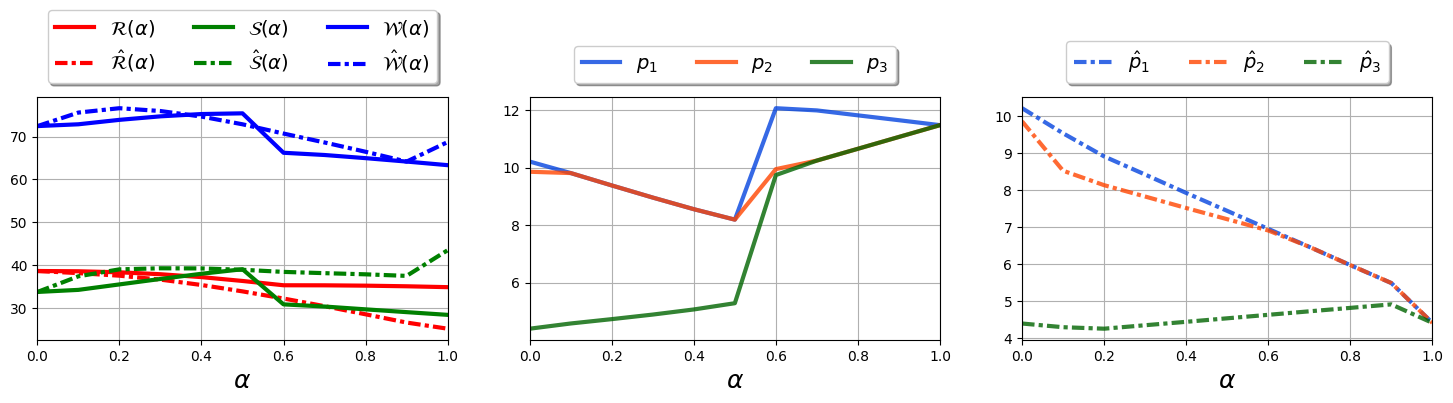

In [25]:
compare_n_3(opt, alg, fairness='Price', criteria='origin')

### Access Fairness

alpha = 0.1
alpha = 0.2
alpha = 0.3
alpha = 0.4
alpha = 0.5
alpha = 0.6
alpha = 0.7
alpha = 0.8
alpha = 0.9
alpha = 1.0


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


pass


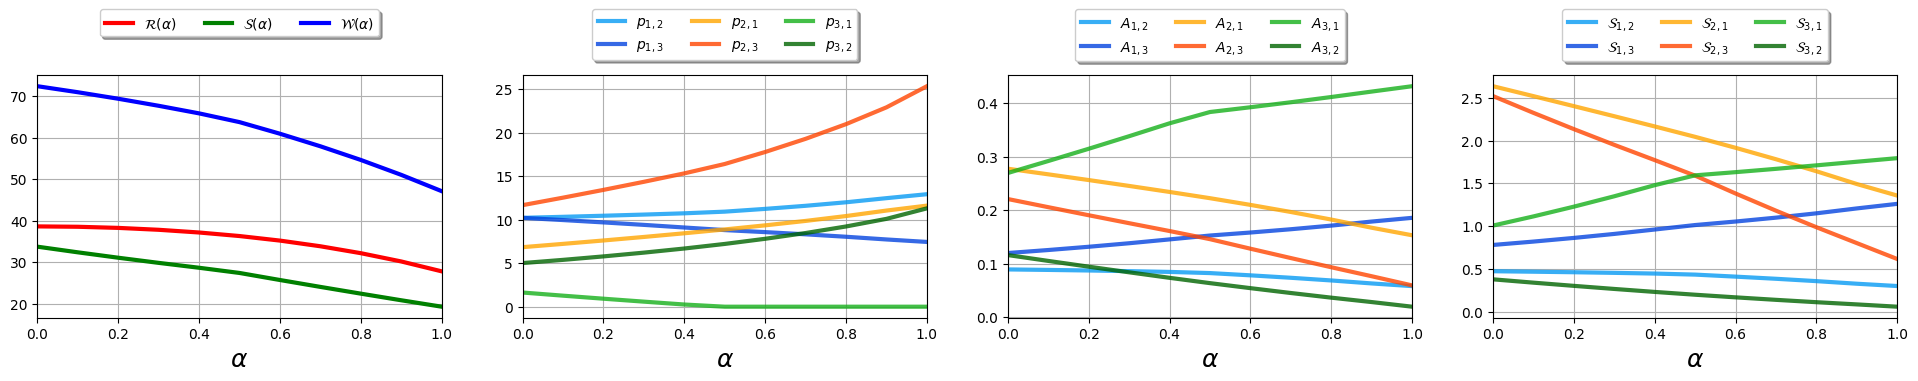

In [26]:
rev_opt, total_sur_opt, sur_opt, p_opt, q_opt, a_opt, weighted_opt = simulator(param, fairness='Access', criteria='origin')

algorithm start
price gap 5.813867057837794
access gap 0.14401274267948372
fail at 6
fail at 4
fail at 6
fail at 9
fail at 0
fail at 6
fail at 9
fail at 0
fail at 1
fail at 6
fail at 0
fail at 0
fail at 3
fail at 7


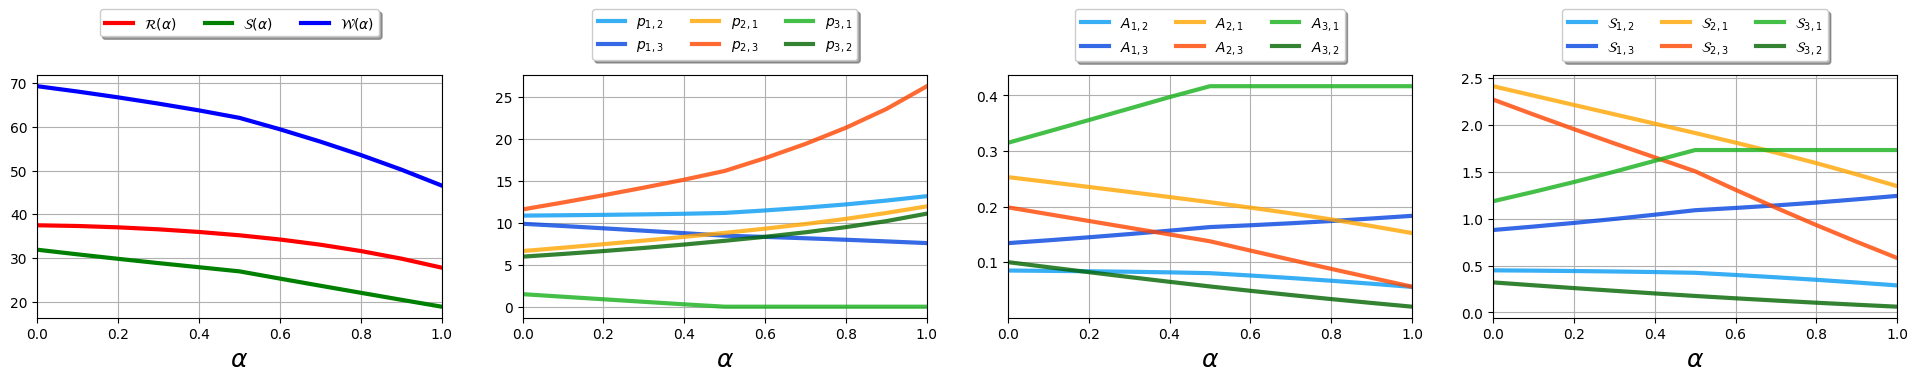

time elapsed 0.09 min


In [27]:
rev_alg, total_sur_alg, sur_alg, p_alg, a_alg, weighted_alg = algorithm_simulator(param, fairness = 'Access', criteria='origin', step=0.1, Delta_W=0.1)
opt = {'rev': rev_opt, 'ts': total_sur_opt, 's': sur_opt, 'p': p_opt, 'q': q_opt, 'a': a_opt, 'w': weighted_opt}
alg = {'rev': rev_alg, 'ts': total_sur_alg, 's': sur_alg, 'p': p_alg, 'a': a_alg, 'w': weighted_alg}

In [28]:
# save_path = '/path/for/pkl/file'
# file_name = f'Access_origin.pkl'
# with open(os.path.join(save_path, file_name), 'wb') as f:
#   pickle.dump({'opt': opt, 'alg': alg}, f)

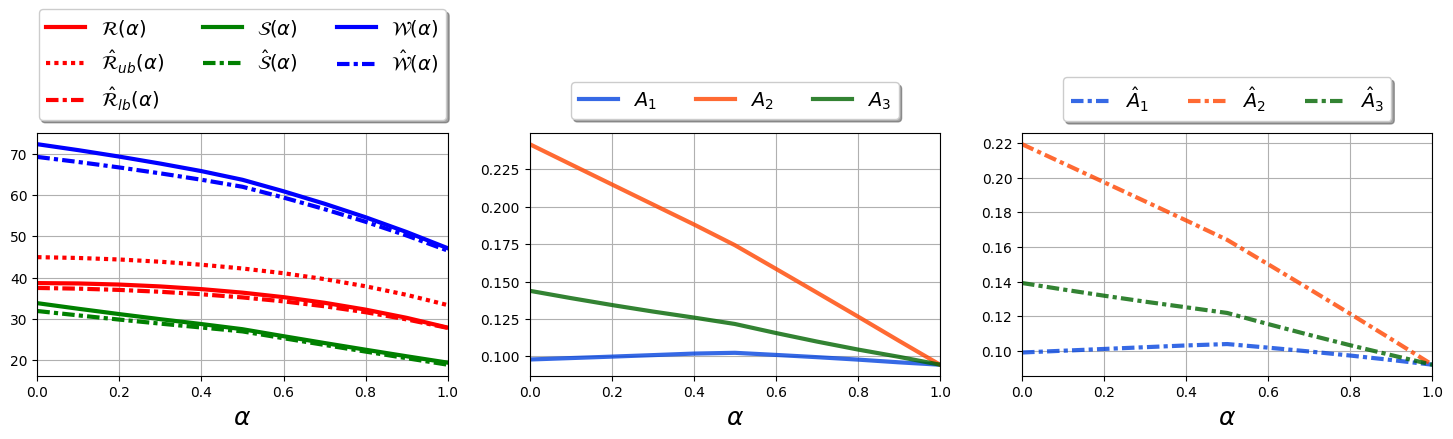

In [29]:
compare_n_3(opt, alg, fairness='Access', criteria = 'origin')

alpha = 0.1
alpha = 0.2
alpha = 0.3
alpha = 0.4


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.5
alpha = 0.6


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.7


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.
  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.8
alpha = 0.9
alpha = 1.0


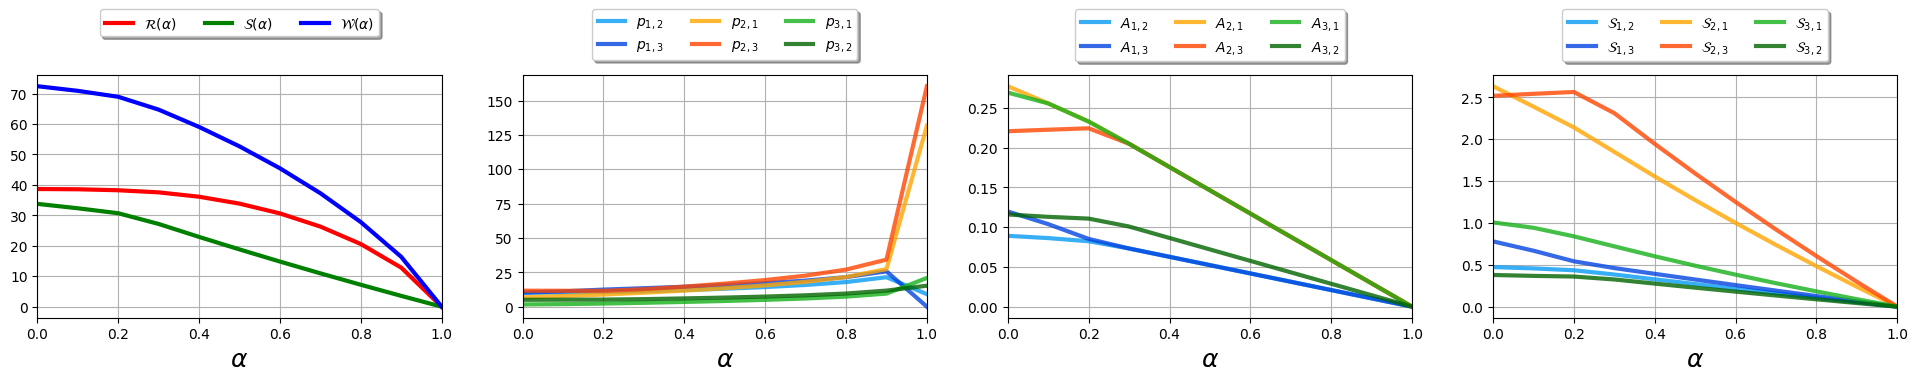

algorithm start
price gap 10.037871516148897
access gap 0.18814228786780546
fail at 0
fail at 2
fail at 3
fail at 5
fail at 7
fail at 8
fail at 9
fail at 1
fail at 6
fail at 8
fail at 2


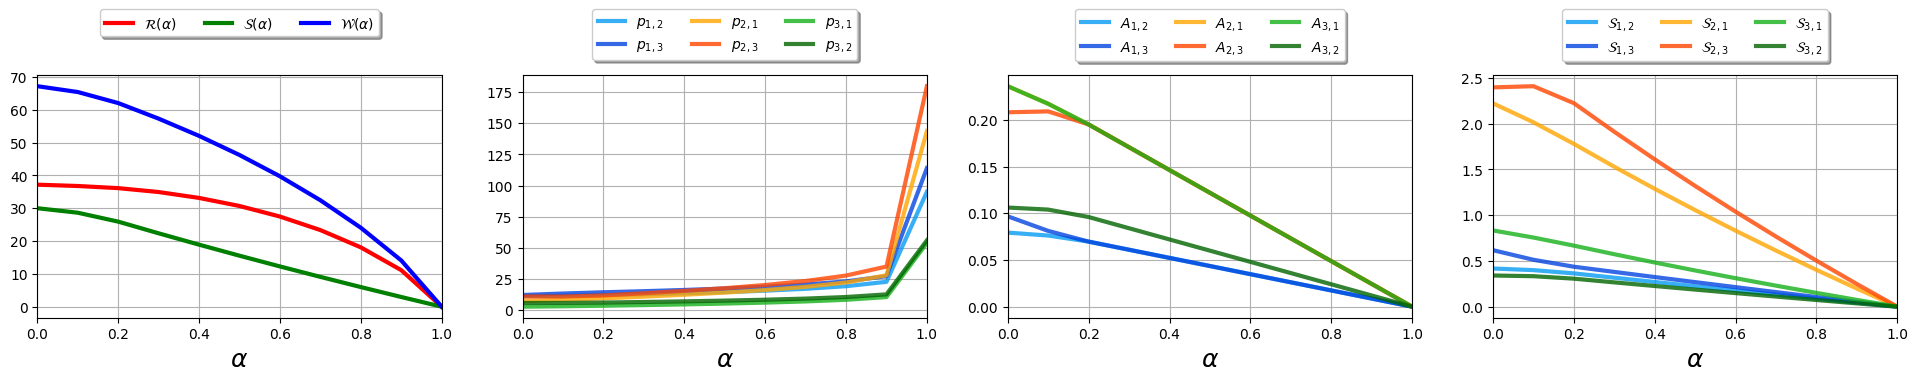

time elapsed 0.10 min


In [30]:
rev_opt, total_sur_opt, sur_opt, p_opt, q_opt, a_opt, weighted_opt = simulator(param, fairness='Access', criteria='trip')
rev_alg, total_sur_alg, sur_alg, p_alg, a_alg, weighted_alg = algorithm_simulator(param, fairness = 'Access', criteria='trip', step=0.1, Delta_W=0.1)
opt = {'rev': rev_opt, 'ts': total_sur_opt, 's': sur_opt, 'p': p_opt, 'q': q_opt, 'a': a_opt, 'w': weighted_opt}
alg = {'rev': rev_alg, 'ts': total_sur_alg, 's': sur_alg, 'p': p_alg, 'a': a_alg, 'w': weighted_alg}

In [31]:
# save_path = '/path/for/pkl/file'
# file_name = f'Access_trip.pkl'
# with open(os.path.join(save_path, file_name), 'wb') as f:
#   pickle.dump({'opt': opt, 'alg': alg}, f)

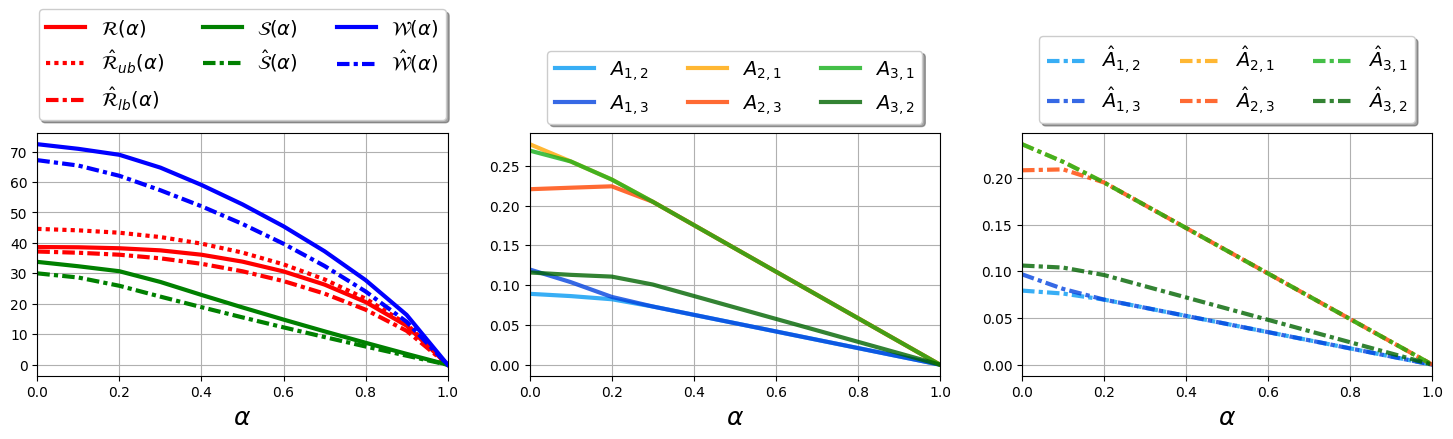

In [32]:
compare_n_3(opt, alg, fairness='Access', criteria='trip')